In [1]:
import datetime
datetime.datetime.now()

datetime.datetime(2019, 7, 19, 18, 15, 17, 216912)

In [298]:
import skimage
from skimage import data, io, filters
from skimage.color import rgb2gray, gray2rgb

import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed
import skimage
import skimage.morphology
import skimage.exposure
import skimage.util
import imageio
from matplotlib.colors import LinearSegmentedColormap
import matplotlib
import numpy as np

from skimage.filters import threshold_otsu

from skimage.morphology import diamond, binary_dilation, closing, square

from skimage.segmentation import clear_border
from skimage.measure import label, regionprops

import SimpleITK as sitk

import math

import openslide

import cv2

In [299]:
REGISTRATION_LEVEL = 4
MASK_FILLING_LEVEL = 4
LEVEL = 4 #admissible values 0 - 4
MANUAL_CROP_X_BOUNDS = {'lower':6000, 'upper':12000}
RESULTS_FOLDER = "results_level_4_registration_level_4_mask_filling_level_4_otsu_reg"

In [4]:
#The crop is not the part of the algorithm
im_ce = io.imread("CK-DAB-H-HR2-16PgR-B.png")[MANUAL_CROP_X_BOUNDS['lower']:MANUAL_CROP_X_BOUNDS['upper'], ...]
im_he = io.imread("HE-HR2-16PgR-B.png")[MANUAL_CROP_X_BOUNDS['lower']:MANUAL_CROP_X_BOUNDS['upper'], ...]

/usr/local/lib/python3.5/dist-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (91115640 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [5]:
def rgb2h(im):
    im_rgb = im[:,:,:3]
    im_hed = rgb2hed(im_rgb)
    im_h = im_hed[:, :, 0]
    return skimage.exposure.rescale_intensity(im_h, out_range=(0,1))

In [6]:
im_ce_gray = rgb2gray(im_ce)
im_he_gray = rgb2gray(im_he)

im_ce_h = rgb2h(im_ce)
im_he_h = rgb2h(im_he)

### Segmentation

In [7]:
#Returns a part of an image given coordinates

def get_subimage(coords, im, relative_coords=(0,0)):
    return im[coords[0]+relative_coords[0]:coords[2]+relative_coords[1], 
              coords[1]+relative_coords[0]:coords[3]+relative_coords[1]]

The segmentation is based on finding objects of a minimal size. Objects are represented by the class Segment.

In [8]:
class Segment:
    def __init__(self, region):
        self.region = region   

    def get_subimage(self, im):
        return im[self.region.bbox[0]:self.region.bbox[2], 
                  self.region.bbox[1]:self.region.bbox[3]]
    
    def get_min_coords(self):
        return self.region.bbox[0], self.region.bbox[1]
    
    def get_max_coords(self):
        return self.region.bbox[2], self.region.bbox[3]
    
    def get_area(self):
        return self.region.area

In [9]:
#Returns a list of objects larger than min_area

def segment_binary_objects(im, min_area):
    bw = closing(im, square(3))
    cleared = clear_border(bw)
    label_image = label(cleared)

    return [Segment(region) for region in regionprops(label_image) if (region.area >= min_area)]

In [10]:
def single_otsu_threshold(im, comparison):
    thr = threshold_otsu(im)
    return comparison(im, thr)

In [11]:
def dual_double_otsu_threshold(im):
    im_thr1 = im * single_otsu_threshold(im, lambda im, thr: im < thr)
    return single_otsu_threshold(im_thr1, lambda im, thr: im > thr)

In [12]:
#Applies the thresholding (Otsu) twice to remove too small and too large values

def double_otsu_threshold(im):
    im_thr11= im * (1-single_otsu_threshold(im, lambda im, thr: im < thr))

    im_thr1 = 1-np.array(single_otsu_threshold(im_thr11, lambda im, thr: im < thr), dtype="float32")

    i=np.array((im_thr1 * im < 1) & (im_thr1 * im > 0), dtype="float32")
    
    return i
    #im_thr11= im * (1-single_otsu_threshold(im, lambda im, thr: im < thr))
    #im_thr1 = im * single_otsu_threshold(im_thr11, lambda im, thr: im < thr)
    #return single_otsu_threshold(im_thr1, lambda im, thr: im > thr)

In [13]:
#Adds an empty margin to an image.

def add_margin(im, mw):
    x = np.zeros((im.shape[0]+(2*mw), im.shape[1]+(2*mw))+im.shape[2:])
    x[mw:im.shape[0]+mw, mw:im.shape[1]+mw] += im
    return x

In [14]:
def get_segment_from_openslide(openslide_img, coordinates, level):
    c = np.array(coordinates) + np.array((6000, 0, 6000, 0)) 
    cc = np.array(((c[1] * 16), c[0] * 16, c[3]-c[1], c[2]-c[0]))

    he_segment = np.array(openslide_img.read_region((cc[0], cc[1]), level,\
                                                    (cc[2] * (2**(4-level)), cc[3] * (2**(4-level)))))
    
    return he_segment

In [15]:
#The number of columns of the samples
NUMBER_OF_COLUMNS = 3
#Minimum object size in the input image
MIN_OBJECT_SIZE_ORIGINAL = 100
#Implementation detail: To remove borders around a sample, we identify the very large object in the center
MIN_OBJECT_SIZE_SECOND = 2000
#The object searching algorithm (regionprops) does not like objects touching the border of the image, so we add a small margin
CORRECTION_MARGIN = 10

In [16]:
def get_segments(im_h, im_gray, openslide_img, level):
    segments_unsorted = segment_binary_objects(add_margin(im_gray > 0, CORRECTION_MARGIN), 100)
    
    #TESTING
    #segments_unsorted = segments_unsorted[:1]
    #/Testing
    
    #Sorts the samples (by rows)
    segments_sorted = sum([
        sorted(
            sorted(segments_unsorted, key=lambda x:x.get_min_coords()[0])[i:i+NUMBER_OF_COLUMNS], 
            key=lambda x: x.get_min_coords()[1]) 
        for i in range(0, math.floor(len(segments_unsorted)), NUMBER_OF_COLUMNS)],[])
    
    im_segments = list(map(lambda s: dual_double_otsu_threshold(s.get_subimage(add_margin(im_h, CORRECTION_MARGIN))), segments_sorted))

    #This part removes the margins in the already segmented samples
    segments2 = list(map(lambda i: segment_binary_objects(add_margin(binary_dilation(i, diamond(2)), CORRECTION_MARGIN), 2000)[0], 
                       im_segments))

    #im_segments2 = list(map(lambda si: si[0].get_subimage(add_margin(si[1], CORRECTION_MARGIN)), zip(segments2, im_segments)))

    #Get coordinates of the samples in the original image
    segment_coordinates = list(map(lambda x: (x[0].get_min_coords()[0] - 2*CORRECTION_MARGIN + x[1].get_min_coords()[0],
                                         x[0].get_min_coords()[1] - 2*CORRECTION_MARGIN + x[1].get_min_coords()[1],
                                         x[0].get_min_coords()[0] - 2*CORRECTION_MARGIN + x[1].get_max_coords()[0],
                                         x[0].get_min_coords()[1] - 2*CORRECTION_MARGIN + x[1].get_max_coords()[1]), 
                              zip(segments_sorted, segments2))) 
    
    return [{'seg_coord':coord_seg} for coord_seg in segment_coordinates]

In [17]:
he_full = openslide.OpenSlide("/mnt/data/scans/AI scans/Cytokeratin_mask_test/HE-HR2-16PgR-B.mrxs")
ce_full = openslide.OpenSlide("/mnt/data/scans/AI scans/Cytokeratin_mask_test/CK-DAB-H-HR2-16PgR-B.mrxs")

In [18]:
segments_ce = get_segments(im_ce_h, im_ce_gray, ce_full, level=LEVEL)
segments_he = get_segments(im_he_h, im_he_gray, he_full, level=LEVEL)

# DEBUG

# /DEBUG

### Registration using SimpleElastix

In [363]:
TRANSFORM_TYPE = "affine"

In [364]:
def register_images(fixed, moving, transform_type):
    elastixImageFilter = sitk.ElastixImageFilter()

    im_fixed = sitk.GetImageFromArray(fixed.astype(np.float32))
    elastixImageFilter.SetFixedImage(im_fixed);

    im_moving = sitk.GetImageFromArray(moving.astype(np.float32))
    elastixImageFilter.SetMovingImage(im_moving);

    elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("translation"))
    elastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap('affine'))
    
    if(transform_type == "bspline"):
        print("Bspline transform in registration.")
        bsplineMap = sitk.GetDefaultParameterMap("bspline")
        bsplineMap['GridSpacingSchedule'] = ['5.57308', '2.803220', '1.410000', '256.000000']
        elastixImageFilter.AddParameterMap(bsplineMap)
        
    elastixImageFilter.Execute()
    
    return elastixImageFilter

In [355]:
im = get_segment_from_openslide(he_full, segments_he[3]['seg_coord'], 4)
io.imsave("he_original.png", im)
he_h = rgb2h(im)
io.imsave("he_hemat.png", np.array(he_h, dtype="float32"))
he_h_otsu = dual_double_otsu_threshold(he_h)
io.imsave("he_otsu.png", np.array(he_h_otsu, dtype = "float32"))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [353]:
im = get_segment_from_openslide(ce_full, segments_ce[3]['seg_coord'], 4)
io.imsave("original.png", im)
ce_h = rgb2h(im)
io.imsave("hemat.png", np.array(ce_h, dtype="float32"))
ce_h_otsu = dual_double_otsu_threshold(ce_h)
io.imsave("otsu.png", np.array(ce_h_otsu, dtype = "float32"))

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [368]:
def _register_images_to_segment(he, ce, transform_type, level):
    print("Still working!")
    
    
    he_gray = rgb2h(get_segment_from_openslide(he_full, he['seg_coord'], level))
    he_gray = he_gray * np.array((he_gray > 0), dtype="float32")
    he_gray_filt = np.array(he_gray<0.9, dtype="float32")

    ce_gray = rgb2h(get_segment_from_openslide(ce_full, ce['seg_coord'], level))
    ce_gray = ce_gray * np.array((ce_gray > 0), dtype="float32")
    ce_gray_filt = np.array(ce_gray<0.9, dtype="float32")
    
    #filt = register_images(he_gray_filt,
    #                       ce_gray_filt,
    #                       transform_type)
    
    he_h = rgb2h(get_segment_from_openslide(he_full, he['seg_coord'], level))
    #he_h_otsu = dual_double_otsu_threshold(he_h)
    
    ce_h = rgb2h(get_segment_from_openslide(ce_full, ce['seg_coord'], level))
    #ce_h_otsu = dual_double_otsu_threshold(ce_h)
    
    filt = register_images(np.array(he_h>0.1, dtype="float32"),# * he_h_otsu,
                          np.array(ce_h>0.1, dtype="float32"),# * ce_h_otsu,
                          transform_type)
    
    #filt = register_images(he_h_otsu,
    #                       ce_h_otsu,
    #                       transform_type)

    return filt

In [369]:
registrationFilters = [_register_images_to_segment(he_seg, ce_seg, TRANSFORM_TYPE, REGISTRATION_LEVEL) for \
                       he_seg, ce_seg in zip(segments_he, segments_ce)]

Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!


# DEBUG

# /DEBUG

### Fill holes in CE

In [305]:
import math

In [306]:
#Minimum area of the hole to be filled
MIN_AREA=math.floor(100/(2**LEVEL))
#Maximum area ...
MAX_AREA=math.floor(200/(2**LEVEL))
#The lower bound on the proportion of the HE stained subarea of a hole to be filled
H_PROPORTION=0.4

In [307]:
def rgb2dab(im):
    im_rgb = im[:,:,:3]
    im_hed = rgb2hed(im_rgb)
    im_h = im_hed[:, :, 2]
    return skimage.exposure.rescale_intensity(im_h, out_range=(0,1))

In [308]:
def fill_holes_in_ce_mask(ce_dab_mask, ce_h_mask):
    labels = skimage.measure.label(1-ce_dab_mask.astype(int))
    regs = skimage.measure.regionprops(labels)

    holes=np.zeros(ce_dab_mask.shape)
    for region in regs:
        if region.area<MAX_AREA:
            coords = tuple(zip(*region.coords))
            if region.area<MIN_AREA:
                holes[coords]=1
            else:
                H_values = (1-ce_h_mask)[coords]
                meanH = np.mean(H_values)
                if meanH >= H_PROPORTION:
                    holes[coords]=1        

    return holes + ce_dab_mask

In [309]:
def _fill_holes(ce, level):
    print("Still working!")
    
    ce_dab_mask = double_otsu_threshold(rgb2dab(get_segment_from_openslide(ce_full,\
                                                      ce['seg_coord'],\
                                                      level)))
    ce_h_mask = dual_double_otsu_threshold(rgb2h(get_segment_from_openslide(ce_full,\
                                                      ce['seg_coord'],\
                                                      level)))
    
    return fill_holes_in_ce_mask(ce_dab_mask, ce_h_mask)

In [310]:
filled_holes = [_fill_holes(ce, MASK_FILLING_LEVEL) for ce in segments_ce]

Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!
Still working!


# DEBUG

# /DEBUG

### Superimpose elastix registered images

In [311]:
def register_mask(mask, reg_filter):
    mask_elastix_im = sitk.GetImageFromArray(mask.astype(np.float32))

    mask_registered_elastix_im = sitk.Transformix(mask_elastix_im, \
                                                          reg_filter.GetTransformParameterMap())
    mask_registered = sitk.GetArrayFromImage(mask_registered_elastix_im)
    
    return mask_registered

In [312]:
def superimpose_mask_on_image(im, mask):
    return np.stack([im[:,:,0],
             im[:,:,1] + mask,
             im[:,:,2]],
            axis=2)

In [313]:
def superimpose_mask_on_he(he, mask, reg_filter, level):
    he_seg_reg_lev = get_segment_from_openslide(he_full, he['seg_coord'], REGISTRATION_LEVEL)
    mask_resized_to_registration_level = cv2.resize(mask, (he_seg_reg_lev.shape[1], 
                                                           he_seg_reg_lev.shape[0]), 
                                                    interpolation = cv2.INTER_CUBIC)
    
    mask_registered = register_mask(mask_resized_to_registration_level, reg_filter)
    
    he_segment = get_segment_from_openslide(he_full, he['seg_coord'], level)
    resized = cv2.resize(mask_registered, (he_segment.shape[1], he_segment.shape[0]), interpolation = cv2.INTER_CUBIC)
    
    r = np.array(single_otsu_threshold(resized, lambda im, thr: im>thr), dtype="float32")
    
    return superimpose_mask_on_image(he_segment, r*255)

In [314]:
def superimpose_mask_on_ce(ce, mask, reg_filter, level):
    ce_segment = get_segment_from_openslide(ce_full, ce['seg_coord'], level)
    resized = cv2.resize(mask, (ce_segment.shape[1], ce_segment.shape[0]), interpolation = cv2.INTER_CUBIC)
    return superimpose_mask_on_image(ce_segment, resized*255)

In [370]:
he_masked_with_ce_with_filled_holes = \
[superimpose_mask_on_he(he, mask, reg, LEVEL) for he, mask, reg in zip(segments_he, filled_holes, registrationFilters)]

In [371]:
ce_masked_with_ce_with_filled_holes = \
[superimpose_mask_on_ce(ce, mask, reg, LEVEL) for ce, mask, reg in zip(segments_ce, filled_holes, registrationFilters)]

### Save results

In [341]:
import os
if(not os.path.exists(RESULTS_FOLDER)): os.mkdir(RESULTS_FOLDER)

In [372]:
for img, index in zip(he_masked_with_ce_with_filled_holes, \
                      range(len(he_masked_with_ce_with_filled_holes))):
    io.imsave(RESULTS_FOLDER + "/he_masked_with_ce_with_filled_holes_elastix_registration_" + TRANSFORM_TYPE + "_" +\
              str(index) + ".png", img)

Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 509.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 510.0]. Convert image to uint8 prior to saving to suppress this warning.


In [373]:
for img, index in zip(ce_masked_with_ce_with_filled_holes, \
                      range(len(ce_masked_with_ce_with_filled_holes))):
    io.imsave(RESULTS_FOLDER + "/ce_masked_with_ce_with_filled_holes_elastix_registration_" + TRANSFORM_TYPE + "_" +\
              str(index) + ".png", img)

Lossy conversion from float64 to uint8. Range [0.0, 489.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 486.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 480.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 492.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 416.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 439.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 471.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 488.0]. Convert image to uint8 prior to saving to suppress this warning.


In [374]:
for img, index in zip(filled_holes, \
                      range(len(filled_holes))):
    io.imsave(RESULTS_FOLDER + "/ce_mask_with_filled_holes_elastix_registration_" + TRANSFORM_TYPE + "_" +\
              str(index) + ".png", img)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:128: UserWarning: results_level_4_registration_level_4_mask_filling_level_4_otsu_reg/ce_mask_with_filled_holes_elastix_registration_affine_4.png is a low contrast image
  warn('%s is a low contrast image' % fname)
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversio

In [329]:
for he, index in zip(segments_he, \
                      range(len(segments_he))):
    io.imsave(RESULTS_FOLDER + "/he_segments_" + "_" +\
              str(index) + ".png", get_subimage(he['seg_coord'], im_he))

IndexError: cannot do a non-empty take from an empty axes.

In [40]:
for ce, index in zip(segments_ce, \
                      range(len(segments_ce))):
    io.imsave(RESULTS_FOLDER + "/ce_segments_" + "_" +\
              str(index) + ".png", get_subimage(ce['seg_coord'], im_ce))

# Full scale (DEBUG)

In [41]:
datetime.datetime.now()

datetime.datetime(2019, 7, 19, 19, 25, 46, 816601)

In [42]:
res = superimpose_mask_on_he(segments_he[0], filled_holes[0], registrationFilters[0], 0)

In [43]:
final_part = res[4000:7000, 3000:6000]
io.imsave("t.png", final_part)

Lossy conversion from float32 to uint8. Range [23.0, 508.0]. Convert image to uint8 prior to saving to suppress this warning.


In [44]:
io.imsave("t.png", filled_holes[0])

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:78: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


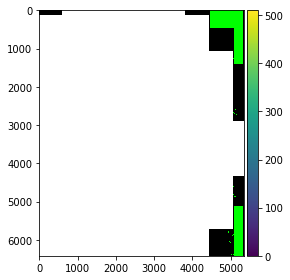

In [45]:
io.imshow(he_masked_with_ce_with_filled_holes[0])
plt.show()

In [46]:
he_seg_reg_lev = get_segment_from_openslide(he_full, segments_he[0]['seg_coord'], REGISTRATION_LEVEL)
mask_resized_to_registration_level = cv2.resize(filled_holes[0], (he_seg_reg_lev.shape[1], 
                                                           he_seg_reg_lev.shape[0]), 
                                                    interpolation = cv2.INTER_CUBIC)

In [47]:
io.imsave("t.png", mask_resized_to_registration_level)

Lossy conversion from float64 to uint8. Range [-0.400820132411706, 1.4083584256236463]. Convert image to uint8 prior to saving to suppress this warning.


## HIERARCHY

In [49]:
im_ce = io.imread("results_level_1_registration_level_1_mask_filling_level_1_otsu_reg/ce_segments__3.png")
im_he = io.imread("results_level_1_registration_level_1_mask_filling_level_1_otsu_reg/he_segments__3.png")

In [50]:
im_ce.shape

(745, 654, 4)

In [53]:
import pickle

In [55]:

pickle.dump(segments_ce, open("segments_ce.pickle", "wb"))
pickle.dump(segments_he, open("segments_he.pickle", "wb"))

In [277]:
he = get_segment_from_openslide(he_full, segments_he[0]['seg_coord'], 1)

In [278]:
he_ = he/255

In [292]:
he_gray = rgb2gray(get_segment_from_openslide(he_full, segments_he[0]['seg_coord'], 1))
ce_gray = rgb2gray(get_segment_from_openslide(ce_full, segments_ce[0]['seg_coord'], 1))

In [296]:
he = get_segment_from_openslide(he_full, segments_he[0]['seg_coord'], 1)
ce = get_segment_from_openslide(ce_full, segments_ce[0]['seg_coord'], 1)

In [297]:
io.imsave("he.png", he)
io.imsave("ce.png", ce)

In [284]:
x_grid = math.floor(he_gray.shape[0]/4)
y_grid = math.floor(he_gray.shape[1]/4)

In [ ]:
he_gray_crop = he_gray[x_grid*2:x_grid*3, y_grid*2:y_grid*3]
ce_gray_crop = ce_gray[x_grid*2:x_grid*3, y_grid*2:y_grid*3]

In [ ]:
he_gray_ = np.array((he_gray<0.9) & (he_gray>0.2), dtype="float32")*he_gray
ce_gray_ = np.array((ce_gray<0.9) & (ce_gray>0.2), dtype="float32")*ce_gray

In [236]:
ih = cv2.resize(he_gray_, (math.floor(he_gray_.shape[1]/8), math.floor(he_gray_.shape[0]/8)), interpolation = cv2.INTER_CUBIC)
ihh = cv2.resize(ih, (he_gray_.shape[1], he_gray_.shape[0]), interpolation = cv2.INTER_CUBIC)
ic = cv2.resize(ce_gray_, (math.floor(ce_gray_.shape[1]/8), math.floor(ce_gray_.shape[0]/8)), interpolation = cv2.INTER_CUBIC)
icc = cv2.resize(ic, (ce_gray_.shape[1], ce_gray_.shape[0]), interpolation = cv2.INTER_CUBIC)

In [238]:
he_gray_.shape

(6416, 5344)

In [281]:
ihh = he_gray
icc = ce_gray

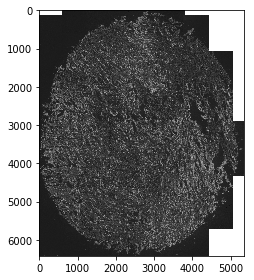

In [283]:
io.imshow(ihh)
plt.show()

In [276]:
io.imsave("h.png", ihh)
io.imsave("c.png",  icc)

Lossy conversion from float64 to uint8. Range [-0.18739263657743394, 0.7994466061978757]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [-0.20519922709614036, 0.9024595665590864]. Convert image to uint8 prior to saving to suppress this warning.


In [244]:
filt = register_images(ihh, icc, "affine")

In [ ]:
elastixImageFilter = sitk.ElastixImageFilter()

im_fixed = sitk.GetImageFromArray(ihh.astype(np.float32))
elastixImageFilter.SetFixedImage(im_fixed);

im_moving = sitk.GetImageFromArray(icc.astype(np.float32))
elastixImageFilter.SetMovingImage(im_moving);

elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("translation"))
elastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap('affine'))

elastixImageFilter.Execute()

In [251]:
filt = elastixImageFilter

In [246]:
im_result = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())

In [179]:
filled_holes_ = filled_holes[3][2*x_grid+100:3*x_grid-100, 2*y_grid+100:3*y_grid-100]

In [167]:
res = superimpose_mask_on_image(he_, register_mask(filled_holes_, filt))

In [247]:
res = superimpose_mask_on_image(he_, im_result)

In [273]:
io.imsave("t.png", res)

Lossy conversion from float64 to uint8. Range [0.1411764705882353, 1.6828684776437048]. Convert image to uint8 prior to saving to suppress this warning.


In [253]:
ce_gray_1 = register_mask(ce_gray, filt)

In [254]:
io.imsave("t.png", superimpose_mask_on_image(he_, ce_gray_1))

Lossy conversion from float64 to uint8. Range [-0.031503189355134964, 1.7705315940520343]. Convert image to uint8 prior to saving to suppress this warning.


In [ ]:
he_gray_ = np.array((he_gray<0.9) & (he_gray>0.2), dtype="float32")*he_gray
ce_gray_ = np.array((ce_gray_1<0.9) & (ce_gray_1>0.2), dtype="float32")*ce_gray_1

In [255]:
ih = cv2.resize(he_gray_, (math.floor(he_gray_.shape[1]/4), math.floor(he_gray_.shape[0]/4)), interpolation = cv2.INTER_CUBIC)
ihh = cv2.resize(ih, (he_gray_.shape[1], he_gray_.shape[0]), interpolation = cv2.INTER_CUBIC)
ic = cv2.resize(ce_gray_, (math.floor(ce_gray_.shape[1]/4), math.floor(ce_gray_.shape[0]/4)), interpolation = cv2.INTER_CUBIC)
icc = cv2.resize(ic, (ce_gray_.shape[1], ce_gray_.shape[0]), interpolation = cv2.INTER_CUBIC)

NameError: name 'he_gray_1' is not defined

In [287]:
he_gray_crop = he_gray[x_grid*2:x_grid*3, y_grid*2:y_grid*3]
ce_gray_crop = ce_gray[x_grid*2:x_grid*3, y_grid*2:y_grid*3]

In [286]:
he_gray_crop

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.20547248, 0.21133083,
        0.21248131],
       [0.        , 0.        , 0.        , ..., 0.22448199, 0.2150508 ,
        0.21642155],
       ...,
       [0.25144964, 0.22739143, 0.22871897, ..., 0.2410468 , 0.21957426,
        0.        ],
       [0.22032073, 0.23594435, 0.25082916, ..., 0.23391089, 0.20722706,
        0.        ],
       [0.        , 0.        , 0.2298962 , ..., 0.24250282, 0.21328039,
        0.20675545]])

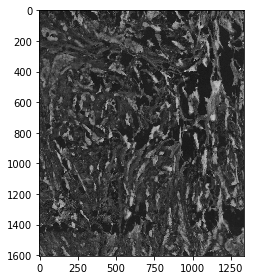

In [288]:

io.imshow(ce_gray_crop)
plt.show()

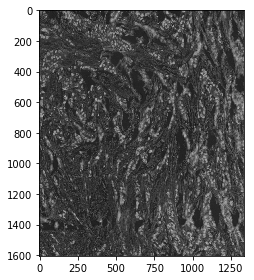

In [289]:

io.imshow(he_gray_crop)
plt.show()

In [268]:
elastixImageFilter = sitk.ElastixImageFilter()

im_fixed = sitk.GetImageFromArray(he_gray_crop.astype(np.float32))
elastixImageFilter.SetFixedImage(im_fixed);

im_moving = sitk.GetImageFromArray(ce_gray_crop.astype(np.float32))
elastixImageFilter.SetMovingImage(im_moving);

elastixImageFilter.SetParameterMap(sitk.GetDefaultParameterMap("translation"))
elastixImageFilter.AddParameterMap(sitk.GetDefaultParameterMap('affine'))

elastixImageFilter.Execute()

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f6b493d1930> >

In [269]:
im_result = sitk.GetArrayFromImage(elastixImageFilter.GetResultImage())

In [271]:
he_crop = he_[x_grid*2:x_grid*3, y_grid*2:y_grid*3, :]

In [272]:
res = superimpose_mask_on_image(he_crop, im_result)

In [275]:
io.imsave("he_gray_crop.png",he_gray_crop)
io.imsave("ce_gray_crop.png", ce_gray_crop)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
